# **How can macroeconomics data be used for FX rate forecasting?**

The data provided by Dan has both the release value, and what the market expectations are for that date. The date format is in YYYYMMDD. There is also a description of what the economic indicator is.

## **Initial assumptions and ideas**
Dan assumes that the size of the relative surprise in the release will have a bigger short term effect on the exchange rate. But he also thinks that it is important to forecast a slightly longer time period than 5 min in order to see if they have a longer term effect.

To analyze the impact of economic indicators on exchange rates, I did pre-processing and statistical analysis. The idea is using the preprocessed data for time series forecasting using ARIMA or sophsticated ML model.


In [1]:
!pip install -q openai langchain pyvis gradio transformers newsapi-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 7

In [2]:
from google.colab import drive
# Read the data into a pandas DataFrame
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# # import pandas as pd

# # df = pd.read_csv(FILE_PATH, skiprows=[0])

# df = pd.read_csv(EUR_MACRO_FILE_PATH, header=None)

# # Create MultiIndex from the first two rows for the columns
# df.columns = pd.MultiIndex.from_tuples([(df.iloc[0, i], df.iloc[1, i]) if i % 3 == 0 else ('', df.iloc[1, i]) for i in range(len(df.columns))])

# # Drop the first two rows that were used to create the MultiIndex
# df = df.drop([0, 1])

EUR_MACRO_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_Dan/FX_Macro_Data_RO_EUR.csv'

df = pd.read_csv(EUR_MACRO_FILE_PATH, header=[0, 1], dtype={'ECO_RELEASE_DT': str})

# Create a list of tuples containing the index name and its corresponding columns
index_columns = [(col[0], col[1]) for col in df.columns]

# Prepare a list to hold the processed data
processed_data = []
num_index_col = 3

# Iterate over the rows in the dataframe
for _, row in df.iterrows():
  # Iterate over the index_columns list in steps of 3
  for i in range(0, len(index_columns), num_index_col):
    # Extract the index name and the corresponding ECO_RELEASE_DT, ACTUAL_RELEASE, BN_SURVEY_MEDIAN
    index_name, _ = index_columns[i]
    eco_release_dt = row[index_columns[i]]
    actual_release = row[index_columns[i+1]]
    bn_survey_median = row[index_columns[i+2]]

    # Append the data to the processed_data list
    processed_data.append({
    'Index': index_name,
    'ECO_RELEASE_DT': eco_release_dt,
    'ACTUAL_RELEASE': actual_release,
    'BN_SURVEY_MEDIAN': bn_survey_median
    })

# Create a new dataframe from the processed data
eur_macro_df = pd.DataFrame(processed_data)
# Convert the date format from YYYYMMDD to a datetime object
eur_macro_df['ECO_RELEASE_DT'] = pd.to_datetime(eur_macro_df['ECO_RELEASE_DT'], format='%Y%m%d')
eur_macro_df.head()

,Index,ECO_RELEASE_DT,ACTUAL_RELEASE,BN_SURVEY_MEDIAN
0,GRCP20YY Index,2010-02-09,0.8,0.8
1,GRIORTMM Index,2010-03-05,4.3,1.3
2,EURR002W Index,2010-01-14,1.0,1.0
3,MPMIFRSA Index,2010-02-03,50.3,59.0
4,ITCPEY Index,2010-02-23,1.3,1.4


### **Using surprise factor for time series forecasting**
In macroeconomics, the surprise factor refers to the difference between the actual economic data released and the market's expectations for that data. It is a measure of how much the actual outcome deviates from the consensus forecast. When an economic indicator is released, analysts and market participants have a median forecast based on their analysis and models. If the actual release value is higher than the forecast, it's considered a positive surprise, and if it's lower, it's a negative surprise. This surprise factor can have significant effects on financial markets as it may lead to immediate adjustments in asset prices. For example, if the actual GDP growth rate is higher than expected, it might lead to an appreciation of the country's currency because it suggests a stronger economy and potential for higher interest rates in the future.

Conversely, if inflation is higher than expected, it could lead to a depreciation of the currency due to fears of economic overheating and loss of purchasing power. Therefore, the surprise factor is particularly important for time series forecasting tasks like predicting currency exchange rates because it represents new information that was not previously priced into the market. When incorporated into econometric models, surprise factors can improve the accuracy of forecasts by accounting for the impact of new economic information on future market movements.

In [4]:
# Calculate the surprise factor as the difference between release value and market expectation
eur_macro_df['Surprise'] = eur_macro_df['ACTUAL_RELEASE'] - eur_macro_df['BN_SURVEY_MEDIAN']
# There are NULLS in the data. That's why I considered more recent data, e.g., 2010 to 2024.
recent_eur_macro_df = eur_macro_df[(eur_macro_df['ECO_RELEASE_DT'] > '2010-01-01') & (eur_macro_df['ECO_RELEASE_DT'] < '2024-04-01')]
recent_eur_macro_df[['Index', 'ECO_RELEASE_DT', 'Surprise']].head()

,Index,ECO_RELEASE_DT,Surprise
0,GRCP20YY Index,2010-02-09,0.0
1,GRIORTMM Index,2010-03-05,3.0
2,EURR002W Index,2010-01-14,0.0
3,MPMIFRSA Index,2010-02-03,-8.7
4,ITCPEY Index,2010-02-23,-0.1


## **GDP and inflation rates**
Both the release value and market expectation are specific figures related to various economic indicators that are released periodically, such as employment numbers, consumer price index, manufacturing data, etc. These figures are keenly watched by market participants as they provide insight into the economic health of a country.

- **Gross Domestic Product (GDP)**: GDP is a broad measure of a nation's overall economic activity and is the most widely used indicator of economic performance.
- **Inflation rate**: inflation is the rate at which the general level of prices for goods and services is rising, and subsequently, purchasing power is falling.

The release values, market expectations, GDP, and inflation rates are essential components of macroeconomic analysis. They are used to gauge the current state of an economy and to forecast future performance. When combined, they can provide a comprehensive picture of economic conditions and help in making more informed predictions about economic trends, including currency exchange rates.

### **Harmonized index of consumer prices (HICP) for inflation rates**
Several economic indicators are relevant for analyzing inflation in the Eurozone, and they help in understanding the different factors that contribute to inflationary pressures. Here are some key indicators:

1. **Consumer Price Index (CPI)**: Measures changes in the price level of a market basket of consumer goods and services purchased by households.
2. **Producer Price Index (PPI)**: Indicates the average changes in prices received by domestic producers for their output and is a leading indicator of consumer price inflation.
3. **Wage Growth**: Higher wages can lead to increased spending and demand, which can push prices up.
4. **Unemployment Rate**: Lower unemployment generally leads to higher wages, which can contribute to inflation.
5. **Money Supply (M3)**: The amount of money circulating in the economy can affect inflation, with a larger money supply potentially leading to higher prices.
6. **Economic Growth (GDP)**: Strong economic growth can lead to inflation if it outpaces the economy's ability to produce goods and services.
7. **Commodity Prices**: Increases in the prices of commodities, such as oil or metals, can lead to higher production costs and consumer prices.
8. **Balance of Trade**: A trade deficit can lead to depreciation of the currency, which can increase the price of imports and contribute to inflation.
9. **Interest Rates**: Set by the European Central Bank (ECB), interest rates can influence inflation by affecting borrowing costs and economic activity.
10. **Exchange Rates**: The strength of the euro against other currencies can affect import prices and, consequently, inflation.

These indicators are often used in conjunction with the Harmonized Index of Consumer Prices (HICP) to provide a comprehensive picture of inflationary trends in the Eurozone. Inflation rates measured HICPs are comparable measures of changes in consumer prices. They are compiled on the basis of harmonised rules and standards, particularly in terms of the coverage of goods and services and the treatment of price observations. The ECB uses the HICP inflation rates for assessing price stability in the euro area.

### **Notes for Dan**
The indexes you mentioned (e.g., GRCP20YY, GRIORTMM, and EURR002W) are likely tied to specific economic indicators within the Eurozone. These could be related to various sectors or aspects of the economy, like consumer confidence, manufacturing activity, or retail sales.

But when it comes to GDP, it is indeed a measure of the economic output of a specific country. However, for an economic zone like the Eurozone, which comprises multiple countries using the euro (EUR) as their currency, analysts often look at the aggregate GDP of the entire zone. This aggregate GDP is a sum of the GDPs of all member countries and provides a broader view of the economic performance of the zone as a whole. To link the economic releases, market expectations, and surprise data with other macroeconomic factors like GDP, it makes sense to use the aggregated GDP of the Eurozone.

Similarly, for inflation rates, we should use the harmonized index of consumer prices (HICP). I did some research and feels like HICP can be a measure to compare and combine inflation rates across different countries in the EU.

I downloaded the HICP data from ECB daat portal: https://data.ecb.europa.eu/data/datasets/ICP?dataset%5B0%5D=Indices%20of%20Consumer%20prices%20%28ICP%29&filterSequence=dataset&advFilterDataset%5B0%5D=Indices%20of%20Consumer%20prices%20%28ICP%29


In [5]:
EUR_HICP_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_ECB/Harmonized_Index_of_Consumer_Prices_HICP_EUR.csv'
eur_hicps_df = pd.read_csv(EUR_HICP_FILE_PATH)

eur_hicps_df = eur_hicps_df[['DATE', 'HICP']]

# Convert the date format from YYYYMMDD to a datetime object
def format_me(date):
  return date.replace('-','')

eur_hicps_df['DATE'] = eur_hicps_df['DATE'].apply(format_me)
eur_hicps_df['DATE'] = pd.to_datetime(eur_hicps_df['DATE'], format='%Y%m%d')
eur_hicps_df = eur_hicps_df[(eur_hicps_df['DATE'] > '2010-01-01') & (eur_hicps_df['DATE'] < '2024-04-01')]
eur_hicps_df.head()

,DATE,HICP
156,2010-01-31,0.9
157,2010-02-28,0.8
158,2010-03-31,1.6
159,2010-04-30,1.6
160,2010-05-31,1.7


In [6]:
# Sort the dataframes by the date columns
recent_eur_macro_df = recent_eur_macro_df.sort_values('ECO_RELEASE_DT')
eur_hicps_df = eur_hicps_df.sort_values('DATE')

# Merge asof with the condition that 'ECO_RELEASE_DT' is earlier than or within 'DATE'
merged_df = pd.merge_asof(recent_eur_macro_df, eur_hicps_df, left_on='ECO_RELEASE_DT', right_on='DATE', direction='forward')
merged_df.head()

,Index,ECO_RELEASE_DT,ACTUAL_RELEASE,BN_SURVEY_MEDIAN,Surprise,DATE,HICP
0,EURR002W Index,2010-01-14,1.0,1.0,0.0,2010-01-31,0.9
1,MPMIFRSA Index,2010-02-03,50.3,59.0,-8.7,2010-02-28,0.8
2,EURR002W Index,2010-02-04,1.0,1.0,0.0,2010-02-28,0.8
3,GRCP20YY Index,2010-02-09,0.8,0.8,0.0,2010-02-28,0.8
4,ITCPEY Index,2010-02-23,1.3,1.4,-0.1,2010-02-28,0.8


### **GDP**
When it comes to GDP, it is indeed a measure of the economic output of a specific country. However, for an economic zone like the Eurozone, which comprises multiple countries using the euro (EUR) as their currency, analysts often look at the aggregate GDP of the entire zone. This aggregate GDP is a sum of the GDPs of all member countries and provides a broader view of the economic performance of the zone as a whole. To link the economic releases, market expectations, and surprise data with other macroeconomic factors like GDP, it makes sense to use the aggregated GDP of the Eurozone.

In [7]:
EUR_Agg_GDP_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_ECB/Aggregated_GDP_Composition_EUR.csv'
eur_agg_gdp_df = pd.read_csv(EUR_Agg_GDP_FILE_PATH)

eur_agg_gdp_df.columns = ['GDP_Date', 'GDP_Period', 'Aggregated_GDP']

# Convert the date format from YYYYMMDD to a datetime object
def format_me(date):
  return date.replace('-','')

eur_agg_gdp_df['GDP_Date'] = eur_agg_gdp_df['GDP_Date'].apply(format_me)
eur_agg_gdp_df['GDP_Date'] = pd.to_datetime(eur_agg_gdp_df['GDP_Date'], format='%Y%m%d')
eur_agg_gdp_df = eur_agg_gdp_df[(eur_agg_gdp_df['GDP_Date'] > '2010-01-01') & (eur_agg_gdp_df['GDP_Date'] < '2024-04-01')]
eur_agg_gdp_df.head()

# Merge asof with the condition that 'ECO_RELEASE_DT' is earlier than or within 'DATE'
eur_agg_gdp_df = eur_agg_gdp_df.sort_values('GDP_Date')
merged_df = pd.merge_asof(merged_df, eur_agg_gdp_df, left_on='ECO_RELEASE_DT', right_on='GDP_Date', direction='forward')
merged_df.head()

,Index,ECO_RELEASE_DT,ACTUAL_RELEASE,BN_SURVEY_MEDIAN,Surprise,DATE,HICP,GDP_Date,GDP_Period,Aggregated_GDP
0,EURR002W Index,2010-01-14,1.0,1.0,0.0,2010-01-31,0.9,2010-03-31,2010Q1,2510003.95
1,MPMIFRSA Index,2010-02-03,50.3,59.0,-8.7,2010-02-28,0.8,2010-03-31,2010Q1,2510003.95
2,EURR002W Index,2010-02-04,1.0,1.0,0.0,2010-02-28,0.8,2010-03-31,2010Q1,2510003.95
3,GRCP20YY Index,2010-02-09,0.8,0.8,0.0,2010-02-28,0.8,2010-03-31,2010Q1,2510003.95
4,ITCPEY Index,2010-02-23,1.3,1.4,-0.1,2010-02-28,0.8,2010-03-31,2010Q1,2510003.95


### **Interest rates**
https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://data.ecb.europa.eu/data/data-categories/ecbeurosystem-policy-and-exchange-rates/official-interest-rates&ved=2ahUKEwiA7Lys8tOFAxV62wIHHeCdBRgQFnoECBUQAQ&usg=AOvVaw2hdbV7YrNKSu8wkXIREo02



In [8]:
EUR_Interest_Rate_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_ECB/Interest_Rates_EUR.csv'
eur_interest_rate_df = pd.read_csv(EUR_Interest_Rate_FILE_PATH)

eur_interest_rate_df.columns = ['Interest_rate_Date', 'Interest_rate_Period', 'Interest_rate']

# Convert the date format from YYYYMMDD to a datetime object
def format_me(date):
  return date.replace('-','')

eur_interest_rate_df['Interest_rate_Date'] = eur_interest_rate_df['Interest_rate_Date'].apply(format_me)
eur_interest_rate_df['Interest_rate_Date'] = pd.to_datetime(eur_interest_rate_df['Interest_rate_Date'], format='%Y%m%d')
eur_interest_rate_df = eur_interest_rate_df[(eur_interest_rate_df['Interest_rate_Date'] > '2010-01-01') & (eur_interest_rate_df['Interest_rate_Date'] < '2024-04-01')]

eur_interest_rate_df = eur_interest_rate_df.sort_values('Interest_rate_Date')

# Merge asof with the condition that 'ECO_RELEASE_DT' is earlier than or within 'DATE'
merged_df = pd.merge_asof(merged_df, eur_interest_rate_df, left_on='ECO_RELEASE_DT', right_on='Interest_rate_Date', direction='forward')

merged_df.head()

,Index,ECO_RELEASE_DT,ACTUAL_RELEASE,BN_SURVEY_MEDIAN,Surprise,DATE,HICP,GDP_Date,GDP_Period,Aggregated_GDP,Interest_rate_Date,Interest_rate_Period,Interest_rate
0,EURR002W Index,2010-01-14,1.0,1.0,0.0,2010-01-31,0.9,2010-03-31,2010Q1,2510003.95,2011-04-13,13 Apr 2011,2.0
1,MPMIFRSA Index,2010-02-03,50.3,59.0,-8.7,2010-02-28,0.8,2010-03-31,2010Q1,2510003.95,2011-04-13,13 Apr 2011,2.0
2,EURR002W Index,2010-02-04,1.0,1.0,0.0,2010-02-28,0.8,2010-03-31,2010Q1,2510003.95,2011-04-13,13 Apr 2011,2.0
3,GRCP20YY Index,2010-02-09,0.8,0.8,0.0,2010-02-28,0.8,2010-03-31,2010Q1,2510003.95,2011-04-13,13 Apr 2011,2.0
4,ITCPEY Index,2010-02-23,1.3,1.4,-0.1,2010-02-28,0.8,2010-03-31,2010Q1,2510003.95,2011-04-13,13 Apr 2011,2.0


In [9]:
merged_df.tail()

,Index,ECO_RELEASE_DT,ACTUAL_RELEASE,BN_SURVEY_MEDIAN,Surprise,DATE,HICP,GDP_Date,GDP_Period,Aggregated_GDP,Interest_rate_Date,Interest_rate_Period,Interest_rate
814,MPMIFRSA Index,2024-03-05,NaN,48.0,NaN,2024-03-31,2.4,NaT,NaN,NaN,NaT,NaN,NaN
815,EURR002W Index,2024-03-07,NaN,NaN,NaN,2024-03-31,2.4,NaT,NaN,NaN,NaT,NaN,NaN
816,GRIORTMM Index,2024-03-07,-11.3,-6.0,-5.3,2024-03-31,2.4,NaT,NaN,NaN,NaT,NaN,NaN
817,GRCP20YY Index,2024-03-12,2.5,2.2,0.3,2024-03-31,2.4,NaT,NaN,NaN,NaT,NaN,NaN
818,ITCPEY Index,2024-03-15,0.8,0.9,-0.1,2024-03-31,2.4,NaT,NaN,NaN,NaT,NaN,NaN


### **Exchange rates: EUR/USD**
https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://data.ecb.europa.eu/data/data-categories/ecbeurosystem-policy-and-exchange-rates/official-interest-rates&ved=2ahUKEwiA7Lys8tOFAxV62wIHHeCdBRgQFnoECBUQAQ&usg=AOvVaw2hdbV7YrNKSu8wkXIREo02



In [ ]:
EUR_Interest_Rate_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_ECB/Interest_Rates_EUR.csv'
eur_interest_rate_df = pd.read_csv(EUR_Interest_Rate_FILE_PATH)

eur_interest_rate_df.columns = ['Interest_rate_Date', 'Period', 'Interest_rate']

# Convert the date format from YYYYMMDD to a datetime object
def format_me(date):
  return date.replace('-','')

eur_interest_rate_df['Interest_rate_Date'] = eur_interest_rate_df['Interest_rate_Date'].apply(format_me)
eur_interest_rate_df['Interest_rate_Date'] = pd.to_datetime(eur_interest_rate_df['Interest_rate_Date'], format='%Y%m%d')
eur_interest_rate_df = eur_interest_rate_df[(eur_interest_rate_df['Interest_rate_Date'] > '2010-01-01') & (eur_interest_rate_df['Interest_rate_Date'] < '2024-04-01')]

eur_interest_rate_df = eur_interest_rate_df.sort_values('Interest_rate_Date')

# Merge asof with the condition that 'ECO_RELEASE_DT' is earlier than or within 'DATE'
merged_df = pd.merge_asof(merged_df, eur_interest_rate_df, left_on='ECO_RELEASE_DT', right_on='Interest_rate_Date', direction='forward')

merged_df.head()

5222    11.504477
5223    11.504477
5224    11.504477
5225    11.504477
5226    11.504477
Name: predicted_mean, dtype: float64


ValueError: Neither `start` nor `end` can be NaT

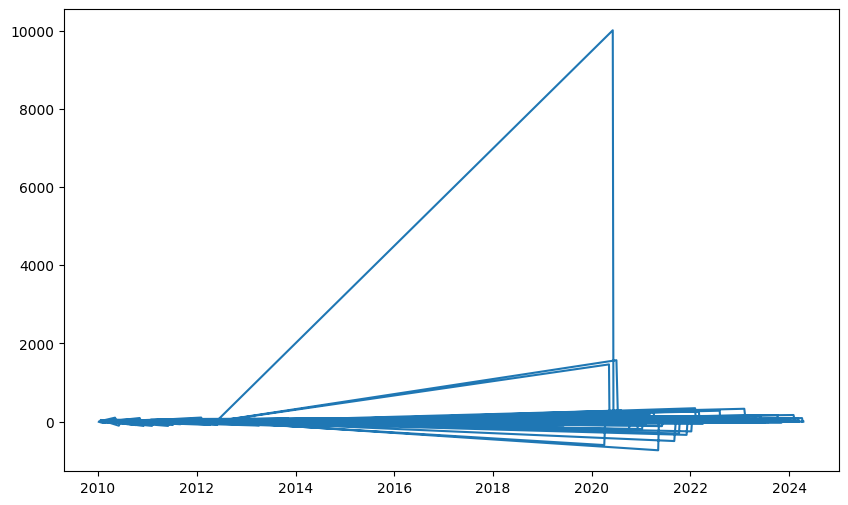

In [403]:
# import pandas as pd

# # Assuming 'df' is your original dataframe with the index data. And 'gdp_df' is a dataframe with the aggregate GDP data for the Eurozone

# # Convert the 'ECO_RELEASE_DT' column to datetime format in both dataframes
# df['ECO_RELEASE_DT'] = pd.to_datetime(df['ECO_RELEASE_DT'])
# gdp_df['Date'] = pd.to_datetime(gdp_df['Date'])

# # Merge the GDP data into your original dataframe on the date column
# combined_df = pd.merge(df, gdp_df, left_on='ECO_RELEASE_DT', right_on='Date', how='left')

# # Now 'combined_df' contains the index data along with the aggregate GDP data for the Eurozone

# # Now, merge the additional economic factors into your original dataframe
# df = df.merge(inflation_df, on='Date', how='left')
# df = df.merge(interest_rates_df, on='Date', how='left')
# df = df.merge(gdp_df, on='Date', how='left')

# # Rename the columns for clarity if needed
# df.rename(columns={'InflationRate': 'Inflation Rate', 'InterestRate': 'Interest Rate', 'GDP': 'GDP'}, inplace=True)

# # Now 'df' contains the surprise factor along with actual release, market expectation, and the additional economic factors

# # Assume 'Exchange_Rate' is a column in your DataFrame
# # Fit an ARIMA model to forecast the exchange rate
# # You may need to adjust the order (p,d,q) based on your data

# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from datetime import datetime
# import matplotlib.pyplot as plt

# model = ARIMA(df['Surprise'], order=(1,1,1))
# model_fit = model.fit()

# # Forecast the next period (adjust 'steps' for your desired forecast length)
# forecast = model_fit.forecast(steps=5)  # For example, 5 days ahead

# # Print the forecasted values
# print(forecast)

# # Optionally, plot the original data and the forecast
# plt.figure(figsize=(10,6))
# plt.plot(df['ECO_RELEASE_DT'], df['Surprise'], label='Original')
# plt.plot(pd.date_range(start=df['ECO_RELEASE_DT'].iloc[-1], periods=5, freq='D'), forecast, label='Forecast', color='red')
# plt.xlabel('ECO_RELEASE_DT')
# plt.ylabel('Surprise')
# plt.title('Surprise Forecast')
# plt.legend()
# plt.show()

To analyze the impact of economic indicators on exchange rates and forecast potential longer-term effects, you can use Python to perform statistical analysis. Below is a sample code snippet that demonstrates how to load the data, calculate the surprise factor, and perform a simple linear regression analysis to understand the relationship between the surprise factor and exchange rate changes.


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
import numpy as np

# Load your spreadsheet data into a DataFrame
# Replace 'your_spreadsheet.csv' with the actual file path
df = pd.read_csv('your_spreadsheet.csv')

# Convert the date format from YYYYMMDD to a datetime object
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# Calculate the surprise factor as the difference between release value and market expectation
df['Surprise'] = df['Release_Value'] - df['Market_Expectation']

# Assume 'Exchange_Rate_Change' is a column in your DataFrame representing the change in exchange rate
# Prepare the features (X) and the target (y)
X = df[['Surprise']]  # Features (2D array for sklearn)
y = df['Exchange_Rate_Change']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict the Exchange Rate Change
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Use the model to forecast future exchange rate changes
# For example, if you have a new surprise factor value
new_surprise_value = np.array([[5]])  # Replace 5 with your actual surprise factor value
predicted_change = model.predict(new_surprise_value)
print(f"Predicted Exchange Rate Change: {predicted_change[0]}")

- 1. Can this be modelled as a time series forecasting with ARIMA or transformer based forecasting algorithm?

- 2. Is it possible to forecast the directionality, e.g., the exchange rate will go up or down?

Time Series Forecasting with ARIMA or Transformer-Based Algorithms:
Yes, the problem can indeed be modeled as a time series forecasting issue. ARIMA (AutoRegressive Integrated Moving Average) is a popular statistical method used for time series forecasting that can capture various patterns in temporal data. However, ARIMA requires the data to be stationary, so you may need to preprocess your data to stabilize the mean and variance over time.

Transformer-based algorithms, like the ones used in machine learning models such as BERT or GPT, can also be applied to time series forecasting. These models can potentially capture complex patterns and long-term dependencies in the data. They are particularly useful when you have a large amount of high-dimensional time series data.

Here's a simple example of how you might set up an ARIMA model for time series forecasting:

In [332]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Assuming 'df' is your DataFrame and it includes a 'Date' and 'Exchange_Rate' column
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.set_index('Date', inplace=True)

# Fit the ARIMA model
model = ARIMA(df['Exchange_Rate'], order=(1, 1, 1))  # Example order, adjust based on your data
arima_result = model.fit()

# Forecast future values
forecast = arima_result.get_forecast(steps=5)  # Adjust steps for your desired forecast length
forecast_index = pd.date_range(start=df.index[-1], periods=5, freq='D')  # Adjust frequency as needed
forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['Forecast'])

print(forecast_df)

SyntaxError: unterminated string literal (detected at line 14) (<ipython-input-332-8e32a555abe4>, line 14)

### **Forecasting directionality**

Forecasting the directionality of exchange rates (whether they will go up or down) is a common goal in financial time series analysis. One approach is to use classification models that predict whether the change will be positive or negative. Another approach is to look at the sign of the forecasted values from a regression or time series model.

For instance, if we're using a regression model, we can interpret positive predicted values as an indication that the exchange rate is expected to increase, and negative values as a decrease. Similarly, with time series models, we can compare the forecasted value with the last known value to determine the direction of the change.

Here's an example of how you might predict directionality using the sign of the forecasted changes:

In [ ]:
# Continuing from the ARIMA example above
# Determine the direction of the change
last_known_rate = df['Exchange_Rate'].iloc[-1]
forecast_df['Direction'] = forecast_df['Forecast'].apply(lambda x: 'Up' if x > last_known_rate else 'Down')

print(forecast_df[['Forecast', 'Direction']])

In this code snippet, the Direction column is added to the forecast DataFrame, indicating whether the forecasted exchange rate is expected to go up or down compared to the last known rate.

Remember, financial markets are influenced by a multitude of factors, and models can only capture so much. It's important to combine model forecasts with domain expertise and other market analyses. Additionally, the performance of these models should be validated using historical data to assess their predictive power.